In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/grbpop/'
sys.path.insert(0, src_dir)

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
from io_grb_pop import root_dir
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import cosmology as cs
import f90_functions as f90f

# General imports
import yaml
import logging
import corner
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.style.use('paper')
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']
Nb_GRBs_glob = int(1e5)
save_fig = True

In [11]:
def compare_pop(config, samples, instruments, obs_constraints, cosmo, params, run_mode=None,
                color=None, lab=None, fig_cstr=None, EpL=False, save_fig=False):
    config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
    incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)

    gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
    gp.draw_GRB_properties(cosmo, params, run_mode=run_mode)
    gp.calc_peak_photon_flux(incl_instruments)
    gp.calc_peak_energy_flux(incl_instruments)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples)
    gp.create_mock_constraints()
    gp.compare_to_observational_constraints(constraints=incl_constraints)
    gp.normalize_to_Stern()
#     gp.normalize_from(nGRB0=nGRB0, nGRB0_err=nGRB0_err)
    gp.summary()

    # Observational constraints
    plt.style.use('presentation')
    if fig_cstr is None:
        fig, axarr = plt.subplots(2,2, figsize=(12,10), tight_layout=True)
        axes = axarr.flatten()
    else:
        fig = fig_cstr
        axes = fig.axes
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab)
    axes[0].legend()

    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    ax = axes[3]
    df = gp.properties
    x, y = st.unbinned_empirical_cdf(df['z'])
    ax.plot(x, y, color=color, linewidth=2, ls='--', alpha=0.8)
    pf.plot_SHOALS_distr(gp,
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color=color,
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')

    return


19:22:52.914 [INFO] Creating cosmology with: OmegaM = 0.27, OmegaL = 0.73, H0 = 70.0
19:22:53.794 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
19:22:53.795 [INFO] Including instruments: ['BATSE', 'BAT']
19:22:53.796 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
19:22:53.846 [INFO] Debug mode activated; plotting z pdf
19:22:53.920 [INFO] Debug mode activated; plotting L pdf
19:22:53.965 [INFO] Debug mode activated; plotting Ep pdf
19:22:54.015 [INFO] Debug mode activated; plotting spectral params pdf
19:22:54.083 [INFO] Starting calculations of peak photon fluxes...
19:22:55.043 [INFO] Debug mode activated; plotting t90 pdf
19:22:55.135 [INFO] Debug mode activated; plotting Cvar pdf
19:22:55.178 [INFO] Starting calculations of peak photon fluxes...
19:22:56.026 [INFO] Starting calculations of peak energy fluxes...
19:22:57.418 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                              

Sample size :1313
Sample size :82
19:22:58.058 [INFO] In compute_CDF_bounds_by_MC: initializing...
19:22:58.065 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
19:22:58.090 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
19:22:58.115 [INFO] In compute_CDF_bounds_by_MC: computing CDF...
19:22:59.610 [INFO] In compute_CDF_bounds_by_MC: plotting...


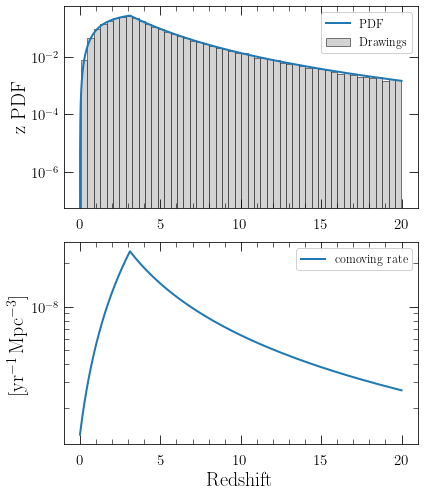

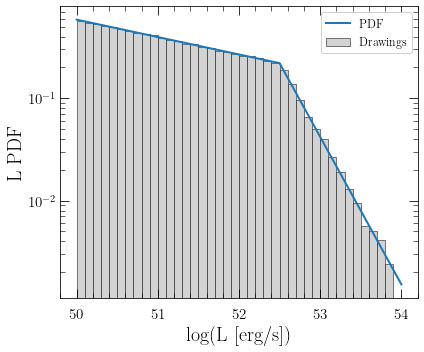

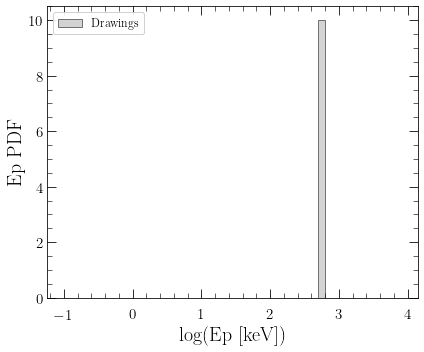

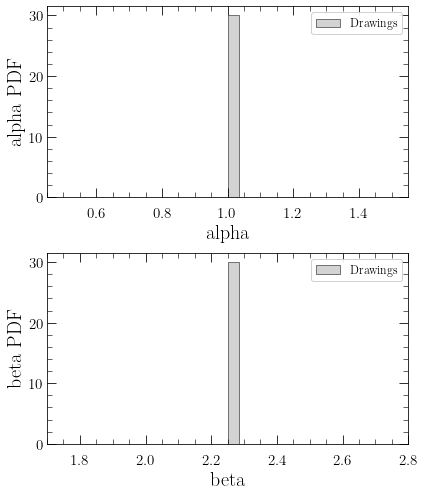

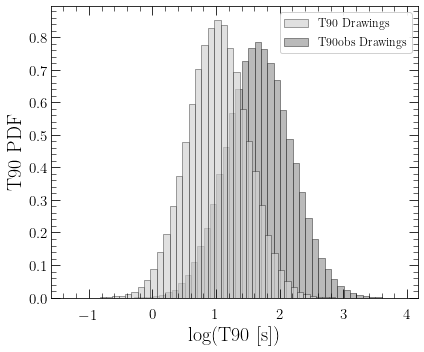

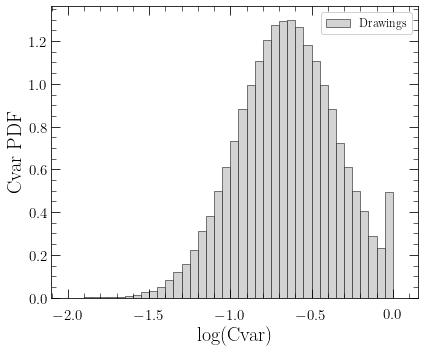

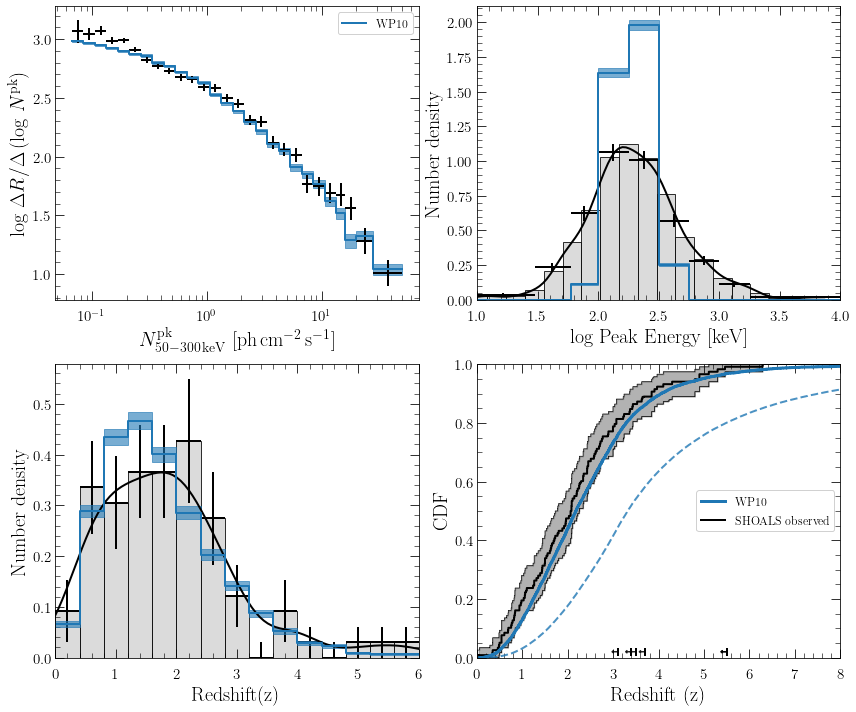

In [12]:
# Wanderman & Piran 2010
WP10 = True
nGRB0 = 1.3e-9 # yr-1 Mpc-3
nGRB0_err = 0.65e-9 # yr-1 Mpc-3
if WP10:
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different (h=0.7 instead of 0.71)
    cosmo = cs.create_cosmology(OmegaM=0.27, OmegaL=0.73, h=0.7, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':52.5,
                                  'slopeL':1.17,
                                  'slopeH':2.44,
                                  'logLmin':50,
                                  'logLmax':54,
                                  'k_evol':0}
    params['redshift_distribution']={'model':'BPL',
                                    'zm':3.11,
                                    'a':2.07,
                                    'b':-1.36}
    params['peak_energy_distribution']={'model':'Fixed',
                                    'Ep0':511.}
    params['spectral_shape']={'model':'Fixed',
                              'shape':'Band',
                              'alpha':1,
                              'beta':2.25}
compare_pop(config, samples, instruments, obs_constraints, cosmo, params,
                color='C0', lab='WP10', fig_cstr=None, EpL=False, save_fig=False)

13:12:40.733 [INFO] Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 70.0
13:12:41.732 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
13:12:41.733 [INFO] Including instruments: ['BATSE', 'BAT']
13:12:41.734 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
13:12:42.075 [INFO] Debug mode activated; plotting z pdf
13:12:42.287 [INFO] Debug mode activated; plotting L pdf
13:12:42.488 [INFO] Debug mode activated; plotting Ep pdf
13:12:42.637 [INFO] Debug mode activated; plotting spectral params pdf
13:12:42.753 [INFO] Starting calculations of peak photon fluxes...
13:12:54.908 [INFO] Debug mode activated; plotting t90 pdf
13:12:55.241 [INFO] Debug mode activated; plotting Cvar pdf
13:12:55.381 [INFO] Starting calculations of peak photon fluxes...
13:13:07.015 [INFO] Starting calculations of peak energy fluxes...
13:13:27.686 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                

Sample size :1313
Sample size :82
13:13:30.663 [INFO] In compute_CDF_bounds_by_MC: initializing...
13:13:30.666 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
13:13:30.684 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
13:13:30.715 [INFO] In compute_CDF_bounds_by_MC: computing CDF...
13:13:32.199 [INFO] In compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


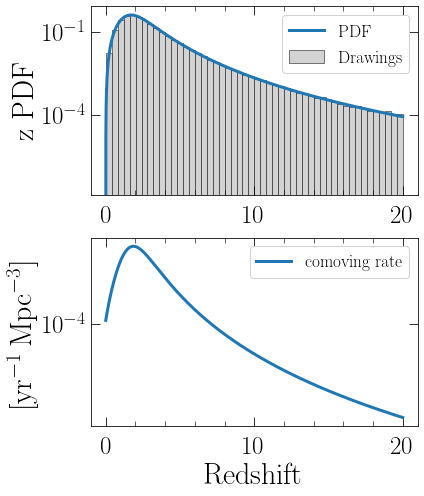

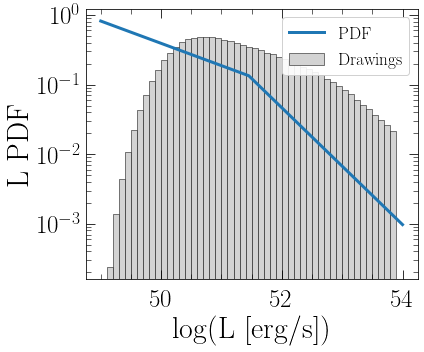

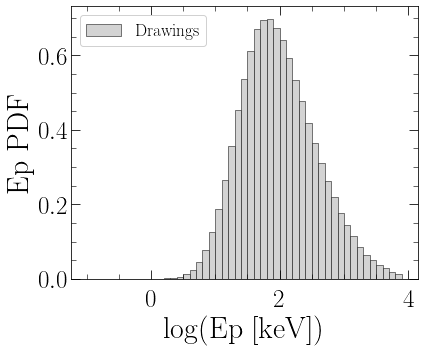

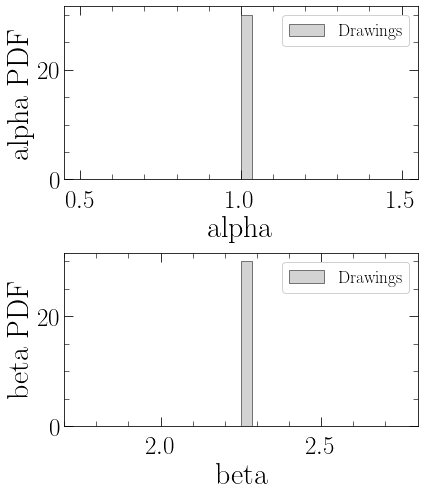

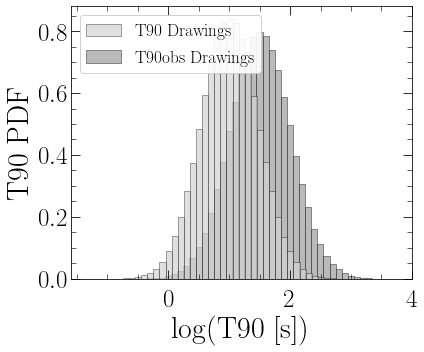

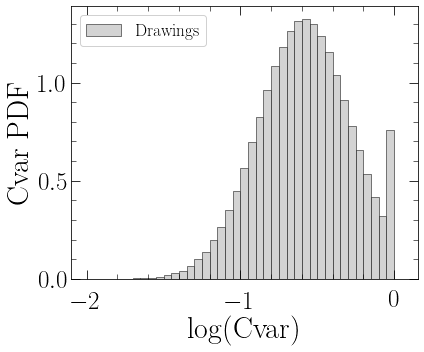

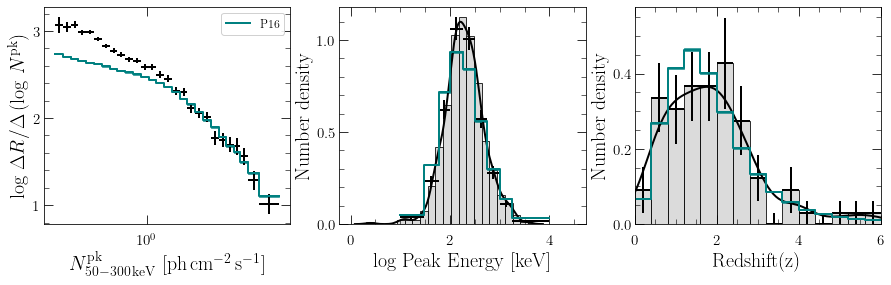

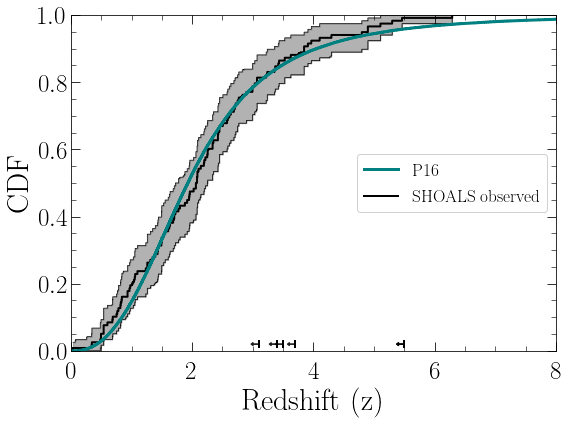

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


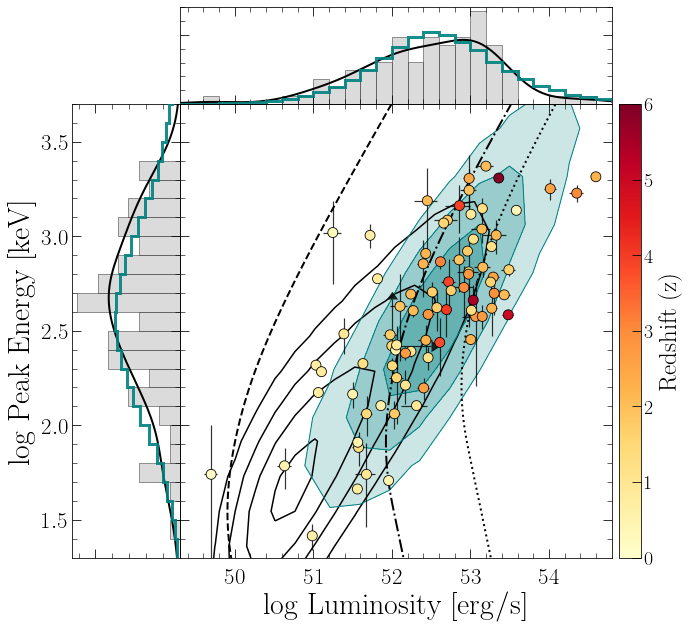

In [3]:
# Pescalli 2016
P16 = True
nGRB0 = 4e-10 # yr-1 Mpc-3
nGRB0_err = 1e-10 # yr-1 Mpc-3
if P16:
    lab = 'P16'
    color = 'teal'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.7, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':51.45,
                                  'slopeL':1.32,
                                  'slopeH':1.84,
                                  'logLmin':49,
                                  'logLmax':54,
                                  'k_evol':2.5}
    params['redshift_distribution']={'model':'MD14',
                                     'a':0.015,
                                     'b':2.7,
                                     'c':2.9,
                                     'd':5.6}
    params['peak_energy_distribution']={'model':'A',
                                        'Ep0':309.,
                                        'alpha_amati':0.54,
                                        'sigmaEp':0.28,
                                        'L0':1.6e52}
    params['spectral_shape']={'model':'Fixed',
                              'shape':'Band',
                              'alpha':1,
                              'beta':2.25}

    config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
    incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
    gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
    gp.compare_to_observational_constraints(constraints=incl_constraints)
    gp.normalize_from(nGRB0=nGRB0, nGRB0_err=nGRB0_err)
#     gp.normalize_to_Stern()
    gp.summary()

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab, color=color)
#     pf.plot_intensity_constraint(axes[0], pop=gp, label='Alt', alt_norm=True, plot_obs=False)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab, color=color)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab, color=color)
    axes[0].legend()
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(gp,
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color=color,
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')

    plt.style.use('paper')
    df = gp.properties
    cond = df['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   plot_left_hist=False, plot_top_hist=False,
                   hist2d_kwargs={'color':'k', 'bins':30,
                                  'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':False})
    pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':color,
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': color,
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':color, 
                                  'contour_kwargs':{'linewidths':1},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{lab}.pdf', bbox_inches='tight')


16:16:28.455 [INFO] Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 70.0
16:16:29.358 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
16:16:29.359 [INFO] Including instruments: ['BATSE', 'BAT']
16:16:29.360 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
16:16:29.638 [INFO] Debug mode activated; plotting z pdf
16:16:29.798 [INFO] Debug mode activated; plotting L pdf
16:16:30.178 [INFO] Debug mode activated; plotting Ep pdf
16:16:30.302 [INFO] Debug mode activated; plotting spectral params pdf
16:16:30.402 [INFO] Starting calculations of peak photon fluxes...
16:16:41.543 [INFO] Debug mode activated; plotting t90 pdf
16:16:41.821 [INFO] Debug mode activated; plotting Cvar pdf
16:16:41.940 [INFO] Starting calculations of peak photon fluxes...
16:16:52.984 [INFO] Starting calculations of peak energy fluxes...
16:17:12.505 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                

Sample size :1313
Sample size :82
16:17:14.057 [INFO] In compute_CDF_bounds_by_MC: initializing...
16:17:14.060 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
16:17:14.076 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
16:17:14.103 [INFO] In compute_CDF_bounds_by_MC: computing CDF...
16:17:15.454 [INFO] In compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


16:17:17.105 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
16:17:17.107 [INFO] Including instruments: ['BATSE', 'BAT']
16:17:17.108 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
16:17:17.388 [INFO] Debug mode activated; plotting z pdf
16:17:17.559 [INFO] Debug mode activated; plotting L pdf
16:17:17.832 [INFO] Debug mode activated; plotting Ep pdf
16:17:17.948 [INFO] Debug mode activated; plotting spectral params pdf
16:17:18.041 [INFO] Starting calculations of peak photon fluxes...
16:17:29.112 [INFO] Debug mode activated; plotting t90 pdf
16:17:29.377 [INFO] Debug mode activated; plotting Cvar pdf
16:17:29.487 [INFO] Starting calculations of peak photon fluxes...
16:17:40.461 [INFO] Starting calculations of peak energy fluxes...
16:17:59.804 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                            

Sample size :1313
Sample size :82


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


16:18:03.036 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
16:18:03.037 [INFO] Including instruments: ['BATSE', 'BAT']
16:18:03.038 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
16:18:03.282 [INFO] Debug mode activated; plotting z pdf
16:20:21.622 [INFO] Debug mode activated; plotting L pdf
16:20:21.791 [INFO] Debug mode activated; plotting Ep pdf
16:20:21.998 [INFO] Debug mode activated; plotting spectral params pdf
16:20:22.102 [INFO] Starting calculations of peak photon fluxes...
16:20:33.374 [INFO] Debug mode activated; plotting t90 pdf


/Users/palmerio/Science_projects/GRB_population_model/grbpop/GRB_population.py:418: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)


16:20:33.637 [INFO] Debug mode activated; plotting Cvar pdf
16:20:33.745 [INFO] Starting calculations of peak photon fluxes...


/Users/palmerio/Science_projects/GRB_population_model/grbpop/GRB_population.py:465: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)


16:20:44.947 [INFO] Starting calculations of peak energy fluxes...
16:21:04.556 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                                  cosmology                                   |
--------------------------------------------------------------------------------
|                               OmegaM = 0.3                                   |
|                               OmegaL = 0.7                                   |
|                                    h = 0.7                                   |
--------------------------------------------------------------------------------
|                            redshift_distribution  

Sample size :1313
Sample size :82


/Users/palmerio/Science_projects/GRB_population_model/grbpop/plotting_functions.py:368: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize, **kwargs)
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/di

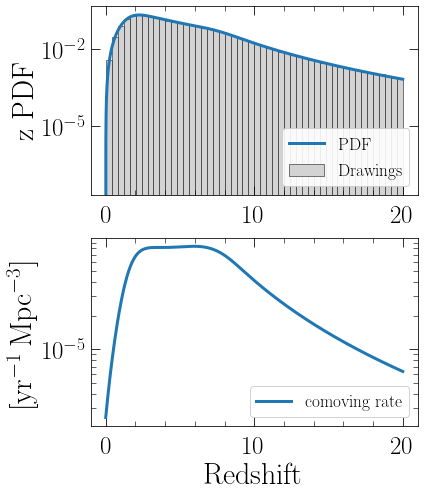

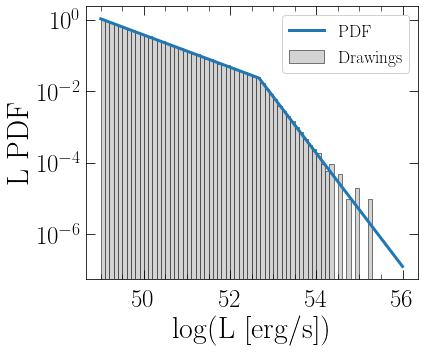

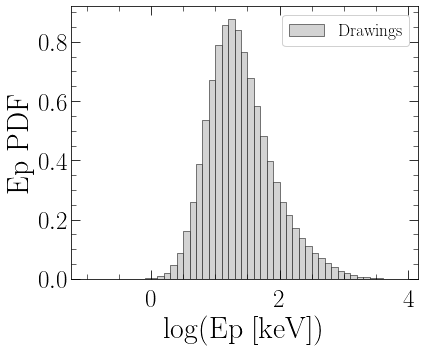

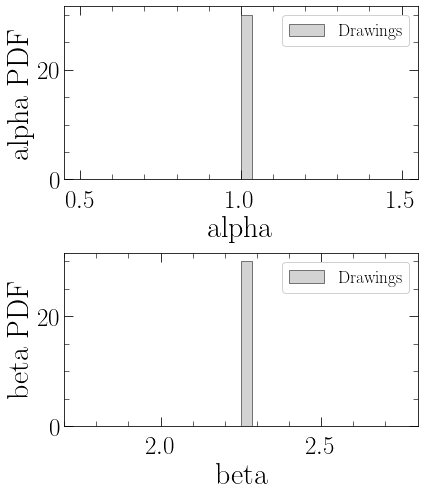

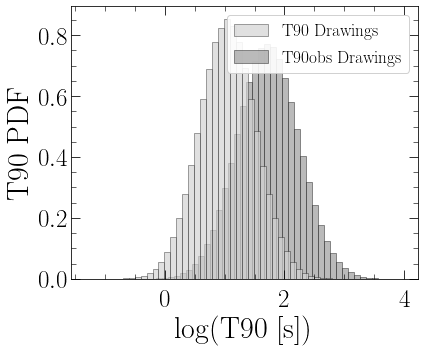

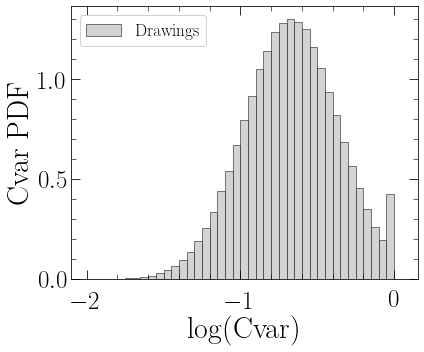

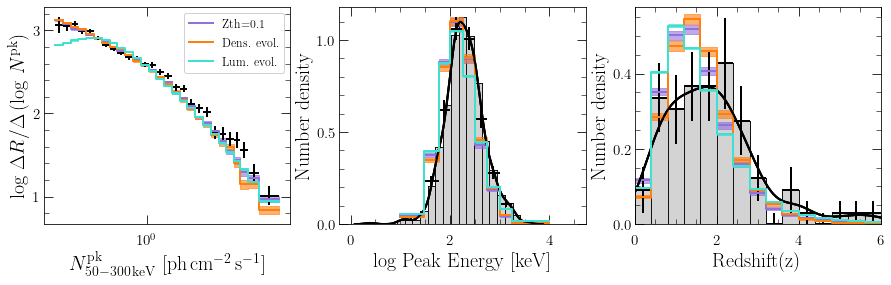

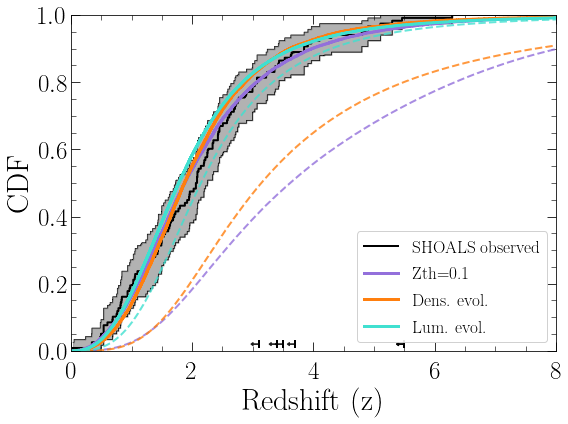

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


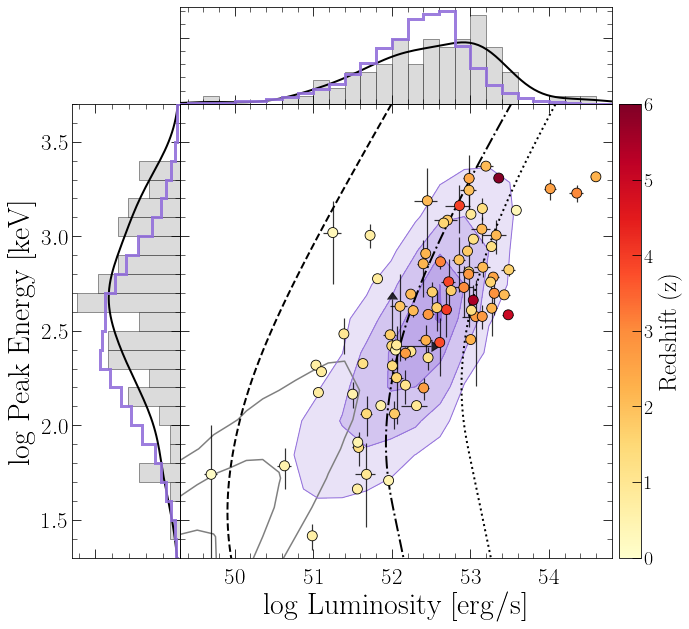

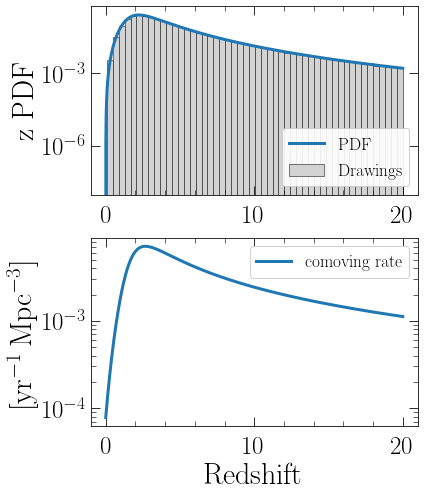

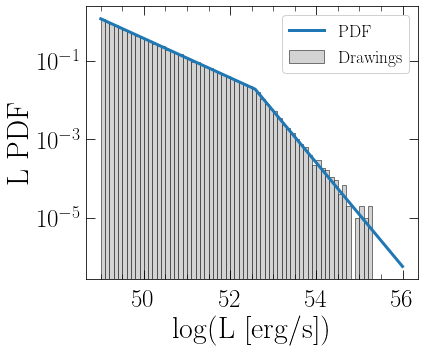

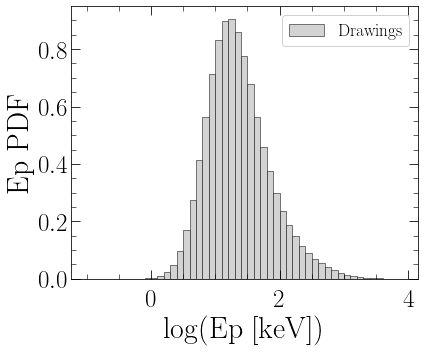

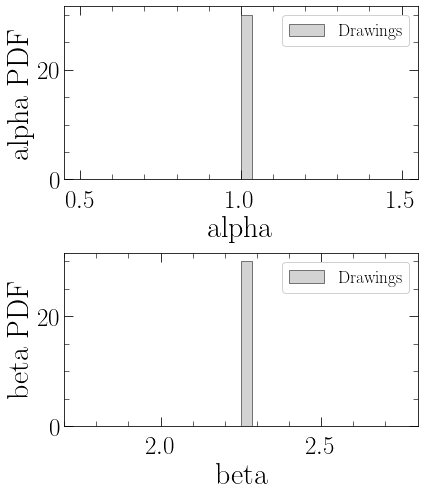

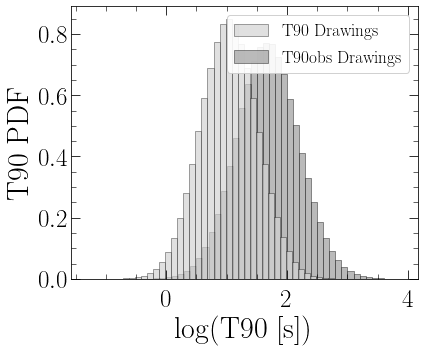

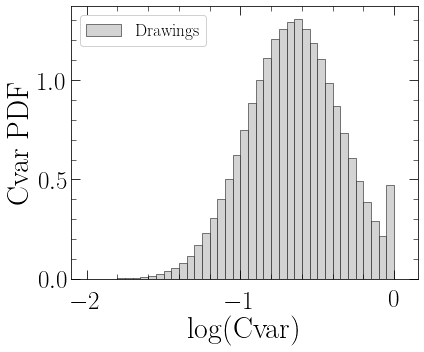

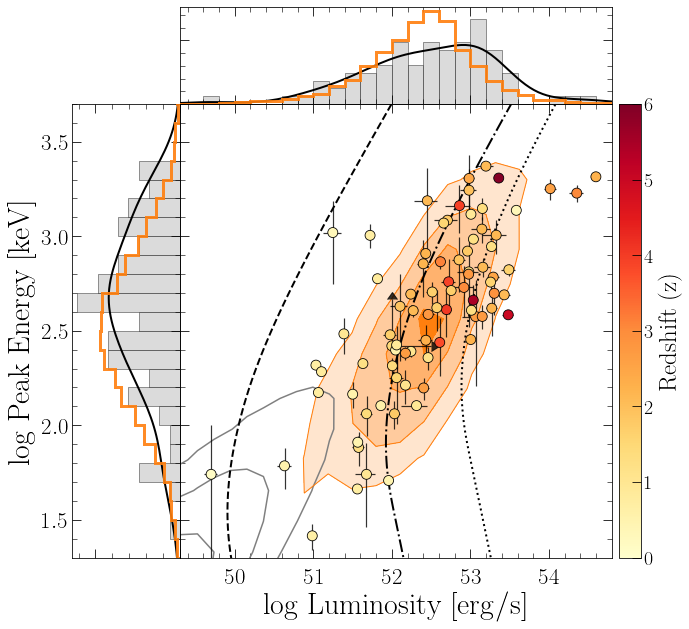

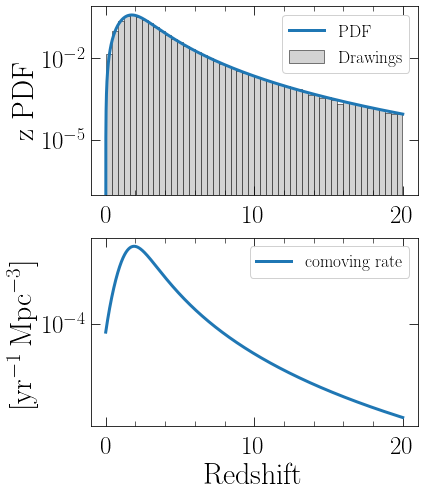

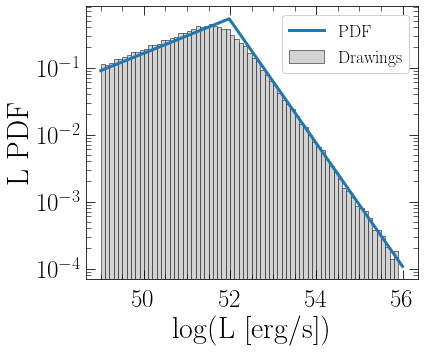

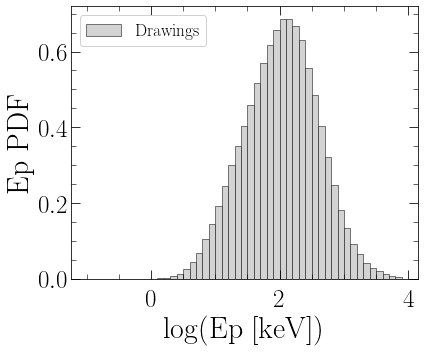

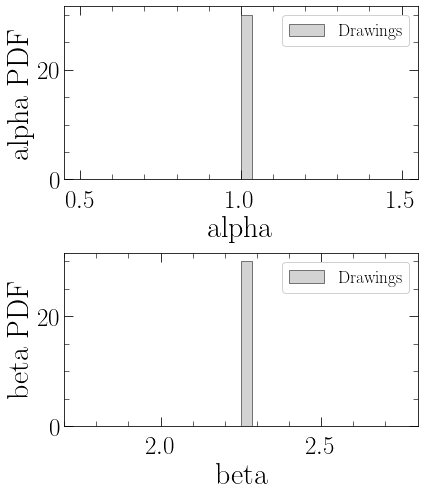

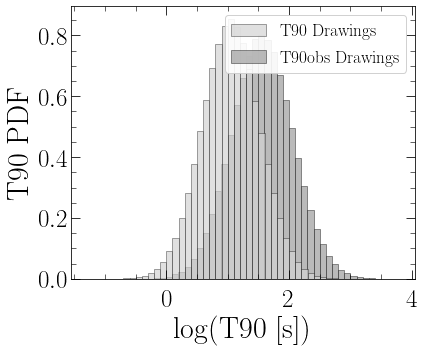

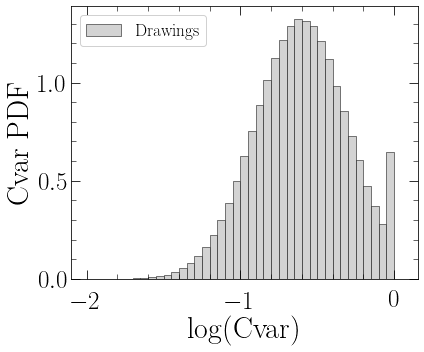

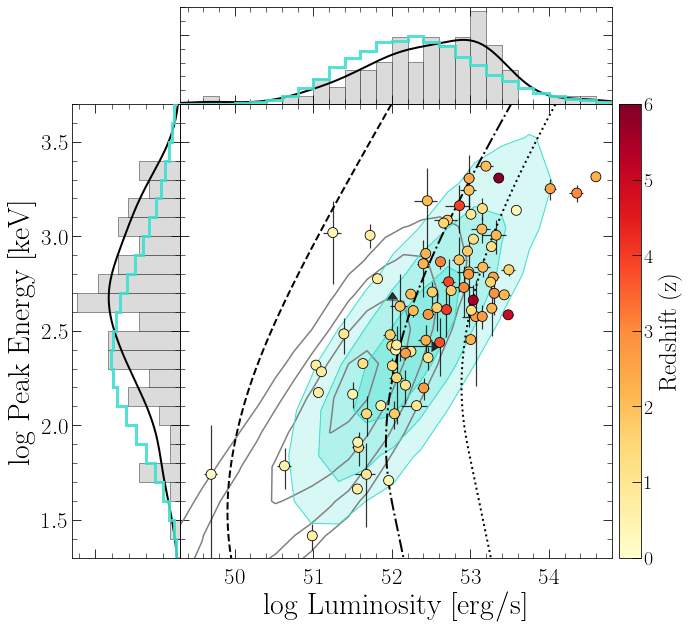

In [4]:
# Salvaterra 2012
S12 = True

Zth_s = [0.1, 1., 1.]
n_dens_s = [None, 1.7, None]
k_evol_s = [0.0, 0.0, 2.1]
slopeL_s = [1.45, 1.50, 0.74]
slopeH_s = [2.58, 2.32, 1.92]
logLbreak_s = [52.67, 52.58, 50.74]
nGRB0_s = np.asarray([4.1e-10, 2.4e-10, 2.1e-10])
nGRB0_err_s = 0.3*nGRB0_s  # this is wrong but it doesn't matter as it isnt used by code
labels = ['Zth=0.1', 'Dens. evol.', 'Lum. evol.']
colors = ['mediumpurple', 'C1', 'turquoise']
save_fig = True
if S12:
    paths_to_dir, paths_to_files = io.generate_paths()
    # Cosmology is slightly different
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.7, zmax=100)
    for i in range(len(Zth_s)):
        config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
        params['luminosity_function']={'model':'EBPLS12',
                                      'logLbreak':logLbreak_s[i],
                                      'slopeL':slopeL_s[i],
                                      'slopeH':slopeH_s[i],
                                      'logLmin':49,
                                      'logLmax':56,
                                      'k_evol':k_evol_s[i]}
        params['redshift_distribution']={'model':'S12',
                                         'Zth':Zth_s[i],
                                         'n_dens':n_dens_s[i]}
        params['peak_energy_distribution']={'model':'A',
                                            'Ep0':337.,
                                            'alpha_amati':0.49,
                                            'sigmaEp':0.28,
                                            'L0':1.6e52}
        params['spectral_shape']={'model':'Fixed',
                                  'shape':'Band',
                                  'alpha':1,
                                  'beta':2.25}

        config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
        incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                               samples=samples,
                                                               instruments=instruments,
                                                               obs_constraints=obs_constraints)
        ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                    ECLAIRs_config=instruments['ECLAIRs'])
        samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

        gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
        gp.draw_GRB_properties(cosmo, params, run_mode='debug')
        gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_photon_fluence(incl_instruments)
        gp.calc_energy_fluence(incl_instruments)
        gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
        gp.create_mock_constraints()
        gp.compare_to_observational_constraints(constraints=incl_constraints)
#         gp.normalize_from(nGRB0=nGRB0_s[i], nGRB0_err=nGRB0_err_s[i])
        gp.normalize_to_Stern()
        gp.summary()

        # Observational constraints
        plt.style.use('presentation')
        if i == 0:
            fig_cstr, axes_cstr = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
        pf.plot_intensity_constraint(axes_cstr[0], pop=gp, label=labels[i], color=colors[i])
        pf.plot_spectral_constraint(axes_cstr[1], pop=gp, label=labels[i], color=colors[i])
        pf.plot_redshift_constraint(axes_cstr[2], pop=gp, label=labels[i], color=colors[i])

        if save_fig and (i == 2):
            axes_cstr[0].legend(loc='upper right')
            fig_cstr.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{labels[i]}.pdf', bbox_inches='tight')

        # SHOALS redshift distribution
        plt.style.use('paper')
        if i == 0:
            fig_SHOALS, ax_SHOALS = plt.subplots(figsize=(8,6))
            pf.plot_SHOALS_z_distr_with_bounds(ax_SHOALS)
        df = gp.properties
        x, y = st.unbinned_empirical_cdf(df['z'])
        ax_SHOALS.plot(x, y, color=colors[i], linewidth=2, ls='--', alpha=0.8)
        pf.plot_SHOALS_distr(gp,
                              key='z',
                              plot_obs=False,
                              cumul=True,
                              ax=ax_SHOALS,
                              mod_color=colors[i],
                              mod_label=labels[i], linewidth=3)

        if save_fig:
            fig_SHOALS.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{labels[i]}.pdf', bbox_inches='tight')

        plt.style.use('paper')
        df = gp.properties
        cond = df['pht_pflx_BAT'] >= 2.6
        fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       plot_left_hist=False, plot_top_hist=False,
                       hist2d_kwargs={'color':'gray', 'bins':30, 
                                      'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':False})
        pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       left_hist_kwargs={'label': None,
                                         'bins':np.linspace(1,4,31),
                                         'edgecolor':colors[i],
                                         'linewidth':3,
                                         'zorder':5,
                                         'alpha':0.9,
                                         'histtype':'step'},
                       top_hist_kwargs={'label': None,
                                        'bins': np.linspace(49,55,31),
                                        'edgecolor': colors[i],
                                        'linewidth':3,
                                        'zorder':5,
                                        'alpha':0.9,
                                        'histtype':'step'},
                       hist2d_kwargs={'color':colors[i], 'label':labels[i],
                                      'contour_kwargs':{'linewidths':1},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':True})
        pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
        if save_fig:
            fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{labels[i]}.pdf', bbox_inches='tight')


13:36:53.266 [INFO] Creating cosmology with: OmegaM = 0.32, OmegaL = 0.68, H0 = 67.0
13:36:54.230 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
13:36:54.232 [INFO] Including instruments: ['BATSE', 'BAT']
13:36:54.232 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
13:36:54.533 [INFO] Debug mode activated; plotting z pdf
13:36:54.715 [INFO] Debug mode activated; plotting L pdf
13:36:54.852 [INFO] Debug mode activated; plotting Ep pdf
13:36:54.945 [INFO] Debug mode activated; plotting spectral params pdf
13:36:55.153 [INFO] Starting calculations of peak photon fluxes...
13:37:07.657 [INFO] Debug mode activated; plotting t90 pdf
13:37:07.991 [INFO] Debug mode activated; plotting Cvar pdf
13:37:08.129 [INFO] Starting calculations of peak photon fluxes...
13:37:19.678 [INFO] Starting calculations of peak energy fluxes...
13:37:40.971 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                              

Sample size :1313
Sample size :82
13:37:43.678 [INFO] In compute_CDF_bounds_by_MC: initializing...
13:37:43.680 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
13:37:43.700 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
13:37:43.741 [INFO] In compute_CDF_bounds_by_MC: computing CDF...
13:37:45.117 [INFO] In compute_CDF_bounds_by_MC: plotting...


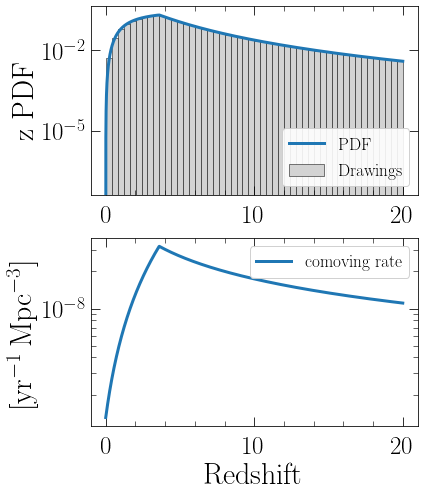

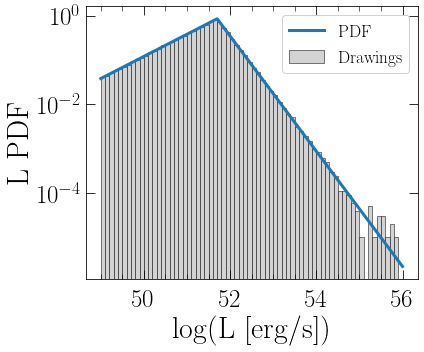

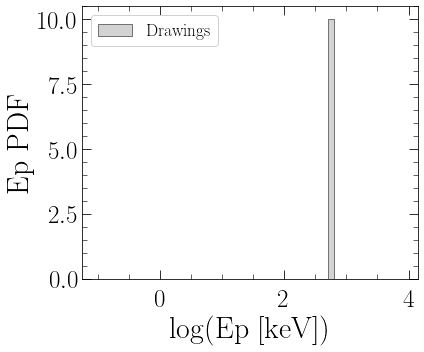

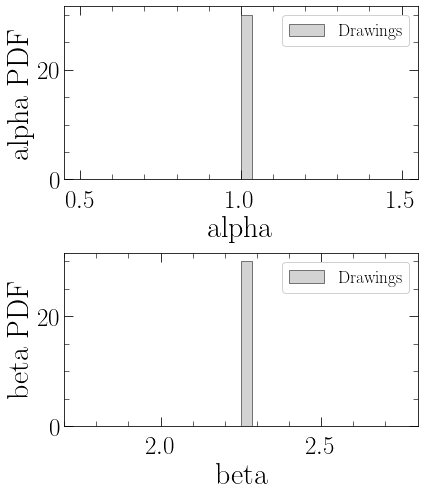

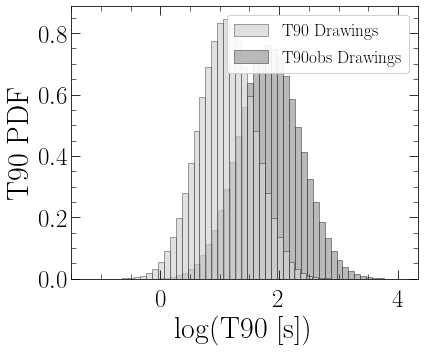

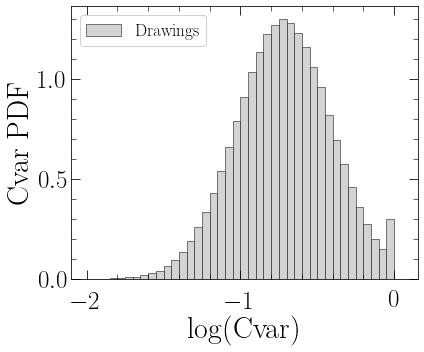

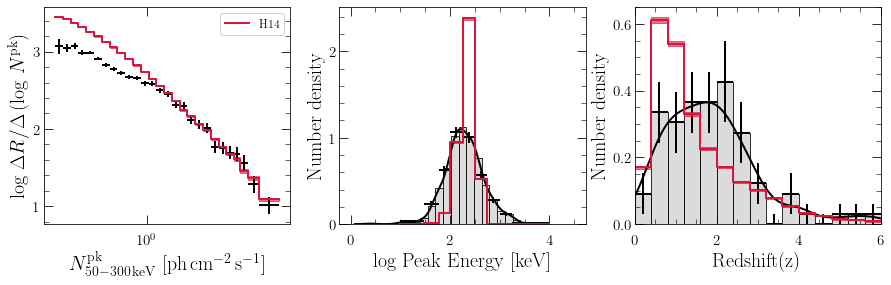

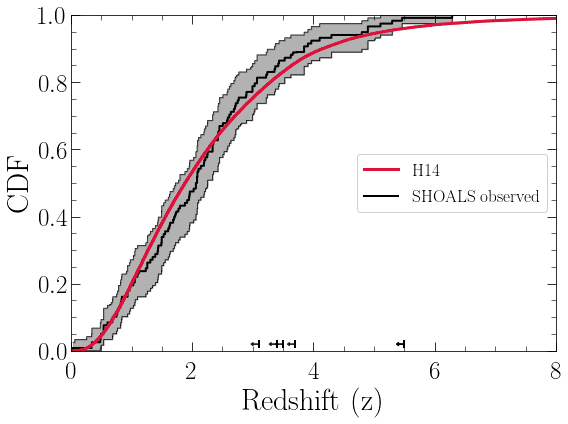

In [7]:
# Howell 2014
H14 = True
nGRB0 = 6e-10 # yr-1 Mpc-3
nGRB0_err = 0.5e-10 # yr-1 Mpc-3
if H14:
    lab = 'H14'
    color = 'crimson'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different
    cosmo = cs.create_cosmology(OmegaM=0.32, OmegaL=0.68, h=0.67, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':51.7,
                                  'slopeL':0.5,
                                  'slopeH':2.3,
                                  'logLmin':49,
                                  'logLmax':56,
                                  'k_evol':0.0}
    params['redshift_distribution']={'model':'BPL',
                                     'zm':3.6,
                                     'a':2.1,
                                     'b':-0.7}
    params['peak_energy_distribution']={'model':'Fixed',
                                        'Ep0':511.}
    params['spectral_shape']={'model':'Fixed',
                              'shape':'Band',
                              'alpha':1,
                              'beta':2.25}

    config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
    incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

    gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
#     gp.compare_to_observational_constraints(constraints=incl_constraints)
    gp.normalize_from(nGRB0=nGRB0, nGRB0_err=nGRB0_err)
    gp.summary()

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab, color=color)
#     pf.plot_intensity_constraint(axes[0], pop=gp, label='Alt', alt_norm=True, plot_obs=False)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab, color=color)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab, color=color)
    axes[0].legend()

    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(gp,
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color=color,
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')


18:57:37.114 [INFO] Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 65.0
18:57:38.276 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
18:57:38.279 [INFO] Including instruments: ['BATSE', 'BAT']
18:57:38.281 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
18:57:38.905 [INFO] Starting calculations of peak photon fluxes...
18:57:50.336 [INFO] Starting calculations of peak photon fluxes...
18:58:01.335 [INFO] Starting calculations of peak energy fluxes...
18:58:23.172 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                                  cosmology                                   |
--------------------------------

Sample size :1313
Sample size :82
18:58:24.955 [INFO] In compute_CDF_bounds_by_MC: initializing...
18:58:24.961 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
18:58:24.982 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
18:58:25.008 [INFO] In compute_CDF_bounds_by_MC: computing CDF...
18:58:26.674 [INFO] In compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


18:58:28.592 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
18:58:28.593 [INFO] Including instruments: ['BATSE', 'BAT']
18:58:28.594 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
18:58:29.168 [INFO] Starting calculations of peak photon fluxes...
18:58:38.517 [INFO] Starting calculations of peak photon fluxes...
18:58:47.708 [INFO] Starting calculations of peak energy fluxes...
18:59:05.609 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                                  cosmology                                   |
--------------------------------------------------------------------------------
|                               Om

Sample size :1313
Sample size :82


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


18:59:09.104 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
18:59:09.106 [INFO] Including instruments: ['BATSE', 'BAT']
18:59:09.107 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
18:59:09.632 [INFO] Starting calculations of peak photon fluxes...
18:59:18.960 [INFO] Starting calculations of peak photon fluxes...
18:59:27.928 [INFO] Starting calculations of peak energy fluxes...
18:59:46.369 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                                  cosmology                                   |
--------------------------------------------------------------------------------
|                               Om

Sample size :1313
Sample size :82


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


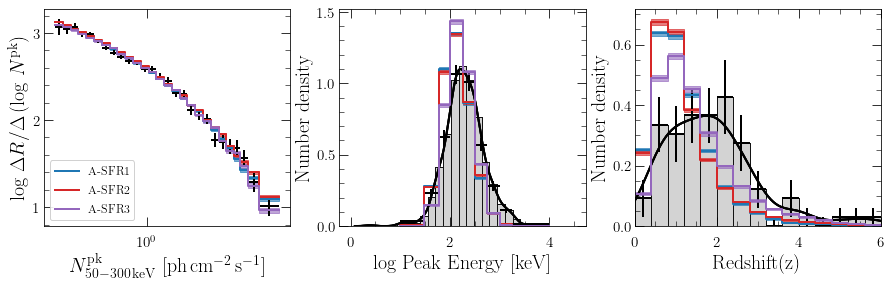

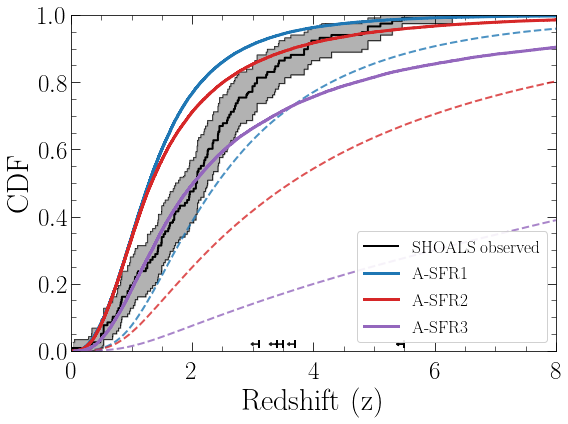

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


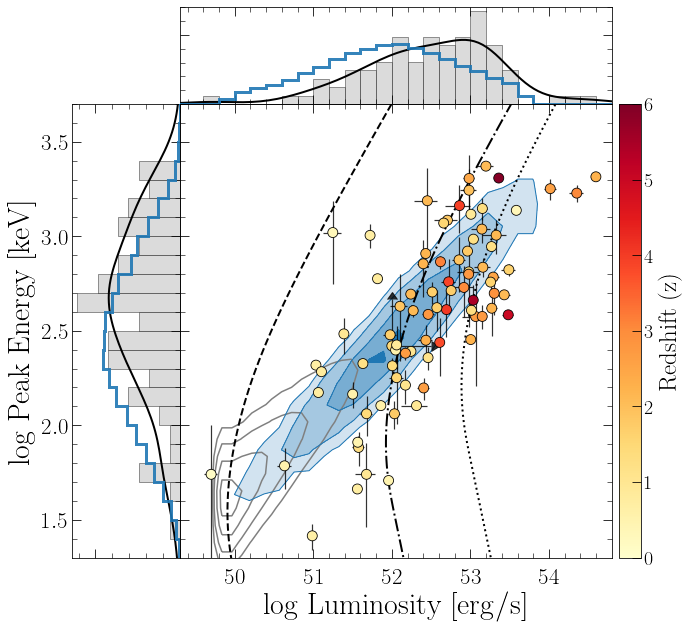

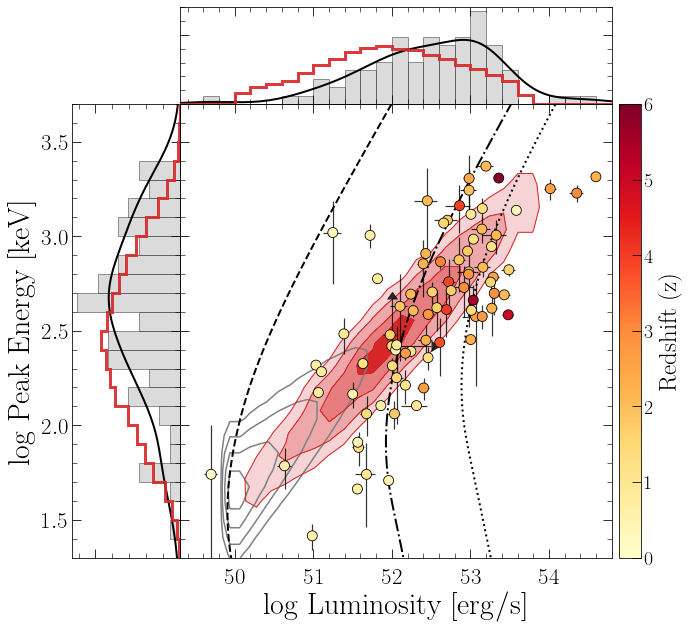

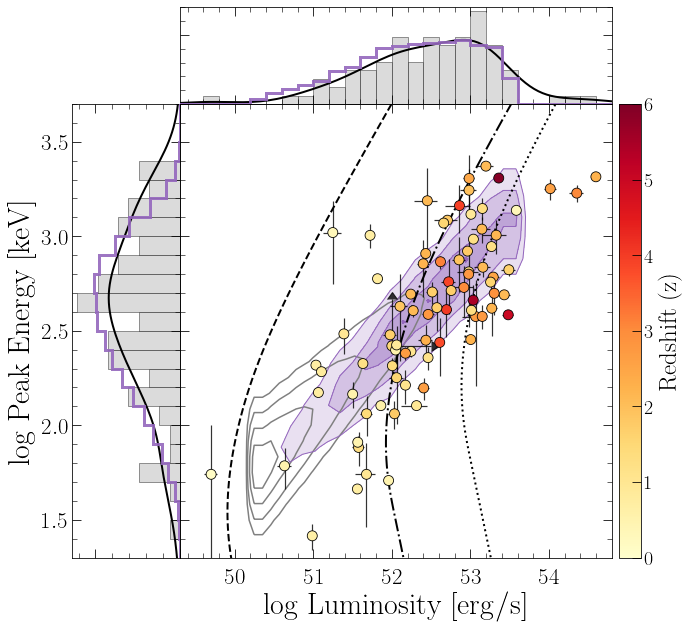

In [6]:
# Daigne 2006 for Amati-like relation
D06 = True
slopes = [1.70, 1.68, 1.54]
logLmins = [49.9, 50.0, 50.3]
logLmaxs = [53.7, 53.7, 53.5]
a_s = [0.320, 0.196, 0.175]
b_s = [3.30, 4.0, 3.67]
c_s = [3.52, 4.0, 3.58]
d_s = [23.6, 14.6, 12.6]
# ngrbs_s = [Nb_GRBs_glob, Nb_GRBs_glob, 10*Nb_GRBs_glob]
nGRB0_s = np.asarray([6.348e-10, 4.905e-10, 1.840e-10])
nGRB0_err_s = 0.3*nGRB0_s  # this is wrong but it doesn't matter as it isnt used by code
labels = ['A-SFR1', 'A-SFR2', 'A-SFR3']
colors = ['C0', 'C3', 'C4']
save_fig = True
if D06:
    paths_to_dir, paths_to_files = io.generate_paths()
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.65, zmax=100)
    for i in range(len(slopes)):
        config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
        config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
        # Cosmology is slightly different
        params['luminosity_function']={'model':'EPL',
                                      'logLmin':logLmins[i],
                                      'logLmax':logLmaxs[i],
                                      'slope':slopes[i],
                                      'k_evol':0.0}
        params['redshift_distribution']={'model':'qD06',
                                        'SFR':i+1,
                                        'mod':'A'}
        params['peak_energy_distribution']={'model':'A',
                                            'Ep0':380.,
                                            'L0':1.6e52,
                                            'alpha_amati':0.43,
                                            'sigmaEp':0.2/np.sqrt(2)}
        params['spectral_shape']={'model':'D06',
                                  'shape':'BPL'}

        incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                               samples=samples,
                                                               instruments=instruments,
                                                               obs_constraints=obs_constraints)
        ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                    ECLAIRs_config=instruments['ECLAIRs'])
        samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

        gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
        gp.draw_GRB_properties(cosmo, params)
        gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_photon_fluence(incl_instruments)
        gp.calc_energy_fluence(incl_instruments)
        gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
        gp.create_mock_constraints()
        gp.compare_to_observational_constraints(constraints=incl_constraints)
        gp.normalize_from(nGRB0=nGRB0_s[i], nGRB0_err=nGRB0_err_s[i])
#         gp.normalize_to_Stern()
        gp.summary()

        # Observational constraints
        plt.style.use('presentation')
        if i == 0:
            fig_cstr, axes_cstr = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
        pf.plot_intensity_constraint(axes_cstr[0], pop=gp, label=labels[i], color=colors[i])
        pf.plot_spectral_constraint(axes_cstr[1], pop=gp, label=labels[i], color=colors[i])
        pf.plot_redshift_constraint(axes_cstr[2], pop=gp, label=labels[i], color=colors[i])
        axes_cstr[2].autoscale(axis='y')
        axes_cstr[2].set_ylim(ymin=0)

        if save_fig and (i == 2):
            axes_cstr[0].legend(loc='lower left')
            fig_cstr.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{labels[i]}.pdf', bbox_inches='tight')

        # SHOALS redshift distribution
        plt.style.use('paper')
        if i == 0:
            fig_SHOALS, ax_SHOALS = plt.subplots(figsize=(8,6))
            pf.plot_SHOALS_z_distr_with_bounds(ax_SHOALS)
        df = gp.properties
        x, y = st.unbinned_empirical_cdf(df['z'])
        ax_SHOALS.plot(x, y, color=colors[i], linewidth=2, ls='--', alpha=0.8)
        pf.plot_SHOALS_distr(gp,
                              key='z',
                              plot_obs=False,
                              cumul=True,
                              ax=ax_SHOALS,
                              mod_color=colors[i],
                              mod_label=labels[i], linewidth=3)

        if save_fig:
            fig_SHOALS.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{labels[i]}.pdf', bbox_inches='tight')

        plt.style.use('paper')
        df = gp.properties
        cond = df['pht_pflx_BAT'] >= 2.6
        fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       plot_left_hist=False, plot_top_hist=False,
                       hist2d_kwargs={'color':'gray', 'bins':30, 
                                      'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':False})
        pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       left_hist_kwargs={'label': None,
                                         'bins':np.linspace(1,4,31),
                                         'edgecolor':colors[i],
                                         'linewidth':3,
                                         'zorder':5,
                                         'alpha':0.9,
                                         'histtype':'step'},
                       top_hist_kwargs={'label': None,
                                        'bins': np.linspace(49,55,31),
                                        'edgecolor': colors[i],
                                        'linewidth':3,
                                        'zorder':5,
                                        'alpha':0.9,
                                        'histtype':'step'},
                       hist2d_kwargs={'color':colors[i], 'label':labels[i],
                                      'contour_kwargs':{'linewidths':1},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':True})
        pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
        if save_fig:
            fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{labels[i]}.pdf', bbox_inches='tight')


18:59:53.872 [INFO] Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 65.0
18:59:54.745 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
18:59:54.747 [INFO] Including instruments: ['BATSE', 'BAT']
18:59:54.748 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
18:59:55.229 [INFO] Starting calculations of peak photon fluxes...
19:00:04.203 [INFO] Starting calculations of peak photon fluxes...
19:00:12.849 [INFO] Starting calculations of peak energy fluxes...
19:00:30.560 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                                  cosmology                                   |
--------------------------------

Sample size :1313
Sample size :82
19:00:32.244 [INFO] In compute_CDF_bounds_by_MC: initializing...
19:00:32.247 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
19:00:32.266 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
19:00:32.291 [INFO] In compute_CDF_bounds_by_MC: computing CDF...
19:00:33.616 [INFO] In compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


19:00:35.263 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
19:00:35.264 [INFO] Including instruments: ['BATSE', 'BAT']
19:00:35.265 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
19:00:35.697 [INFO] Starting calculations of peak photon fluxes...
19:00:44.809 [INFO] Starting calculations of peak photon fluxes...
19:00:53.578 [INFO] Starting calculations of peak energy fluxes...
19:01:11.341 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                                  cosmology                                   |
--------------------------------------------------------------------------------
|                               Om

Sample size :1313
Sample size :82


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


19:01:14.584 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
19:01:14.585 [INFO] Including instruments: ['BATSE', 'BAT']
19:01:14.586 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
19:01:15.037 [INFO] Starting calculations of peak photon fluxes...
19:01:24.163 [INFO] Starting calculations of peak photon fluxes...
19:01:33.263 [INFO] Starting calculations of peak energy fluxes...
19:01:51.387 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                                  cosmology                                   |
--------------------------------------------------------------------------------
|                               Om

Sample size :1313
Sample size :82


/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/grbpop/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


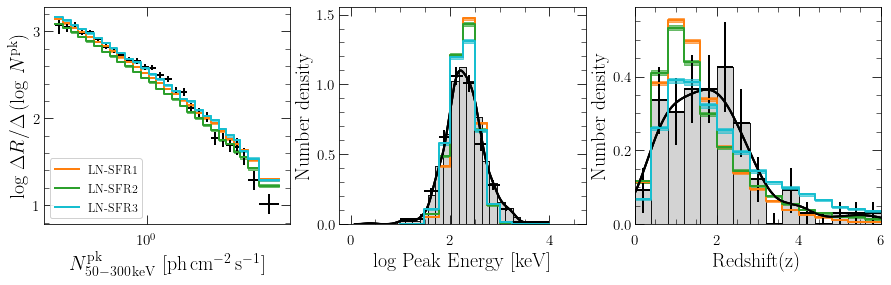

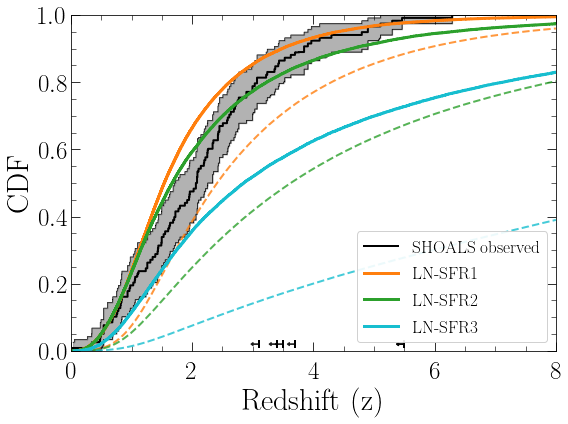

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


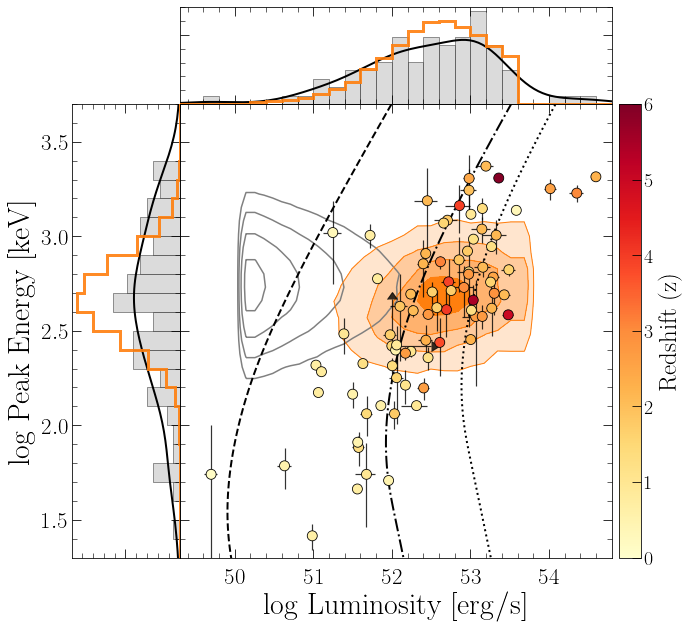

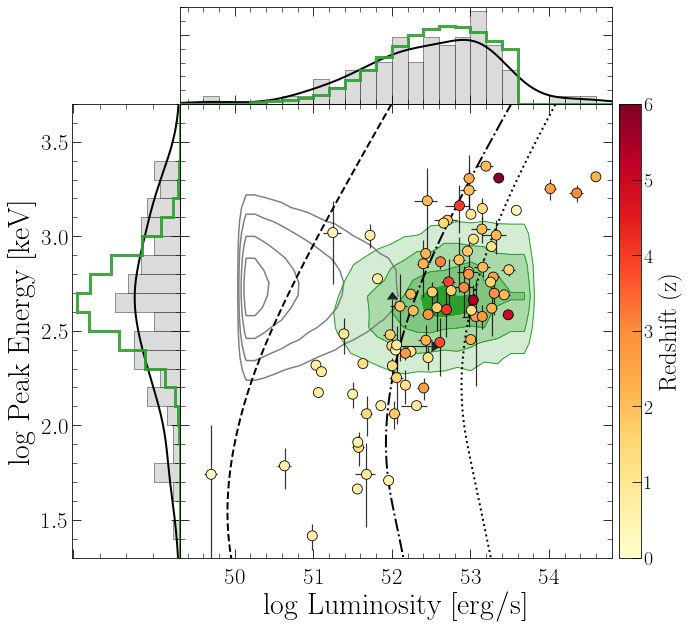

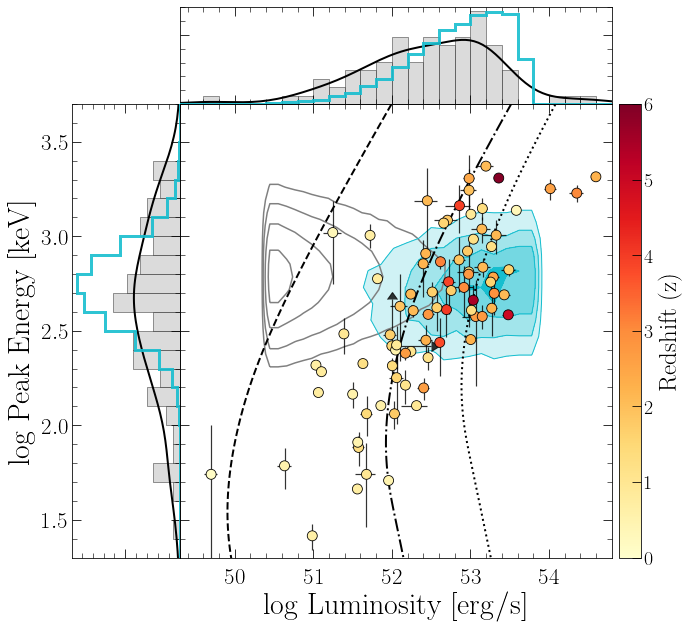

In [7]:
# Daigne 2006 for LogNormal relation
D06 = True
slopes = [1.62, 1.62, 1.52]
logLmins = [50.2, 50.2, 50.5]
logLmaxs = [53.6, 53.6, 53.7]
Ep0s = [10**2.74, 10**2.73, 10**2.79]
a_s = [0.320, 0.196, 0.175]
b_s = [3.30, 4.0, 3.67]
c_s = [3.52, 4.0, 3.58]
d_s = [23.6, 14.6, 12.6]
ngrbs_s = [10*Nb_GRBs_glob, 10*Nb_GRBs_glob, 10*Nb_GRBs_glob]
nGRB0_s = np.asarray([3.967e-10, 3.066e-10, 1.580e-10])  # 9.890e-11
nGRB0_err_s = 0.3*nGRB0_s # this is wrong but it doesn't matter as it isnt used by code
labels = ['LN-SFR1', 'LN-SFR2', 'LN-SFR3']
colors = ['C1', 'C2', 'C9']
if D06:
    paths_to_dir, paths_to_files = io.generate_paths()
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.65, zmax=100)
    for i in range(len(slopes)):
        config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
        config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
        # Cosmology is slightly different
        params['luminosity_function']={'model':'EPL',
                                      'logLmin':logLmins[i],
                                      'logLmax':logLmaxs[i],
                                      'slope':slopes[i],
                                      'k_evol':0.0}
        params['redshift_distribution']={'model':'qD06',
                                         'SFR':i+1,
                                         'mod':'LN'}
        params['peak_energy_distribution']={'model':'LN',
                                            'Ep0':Ep0s[i],
                                            'sigmaEp':0.3/np.sqrt(2)}
        params['spectral_shape']={'model':'D06',
                                  'shape':'BPL'}

        incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                               samples=samples,
                                                               instruments=instruments,
                                                               obs_constraints=obs_constraints)
        ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                    ECLAIRs_config=instruments['ECLAIRs'])
        samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

        gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
        gp.draw_GRB_properties(cosmo, params)
        gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_photon_fluence(incl_instruments)
        gp.calc_energy_fluence(incl_instruments)
        gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
        gp.create_mock_constraints()
        gp.compare_to_observational_constraints(constraints=incl_constraints)
        gp.normalize_from(nGRB0=nGRB0_s[i], nGRB0_err=nGRB0_err_s[i])
        gp.summary()

        # Observational constraints
        plt.style.use('presentation')
        if i == 0:
            fig_cstr, axes_cstr = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
        pf.plot_intensity_constraint(axes_cstr[0], pop=gp, label=labels[i], color=colors[i])
        pf.plot_spectral_constraint(axes_cstr[1], pop=gp, label=labels[i], color=colors[i])
        pf.plot_redshift_constraint(axes_cstr[2], pop=gp, label=labels[i], color=colors[i])

        if save_fig and (i==2):
            axes_cstr[0].legend(loc='lower left')
            fig_cstr.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{labels[i]}.pdf', bbox_inches='tight')

        # SHOALS redshift distribution
        plt.style.use('paper')
        if i == 0:
            fig_SHOALS, ax_SHOALS = plt.subplots(figsize=(8,6))
            pf.plot_SHOALS_z_distr_with_bounds(ax_SHOALS)
        df = gp.properties
        x, y = st.unbinned_empirical_cdf(df['z'])
        ax_SHOALS.plot(x, y, color=colors[i], linewidth=2, ls='--', alpha=0.8)
        pf.plot_SHOALS_distr(gp,
                              key='z',
                              plot_obs=False,
                              cumul=True,
                              ax=ax_SHOALS,
                              mod_color=colors[i],
                              mod_label=labels[i], linewidth=3)

        if save_fig:
            fig_SHOALS.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{labels[i]}.pdf', bbox_inches='tight')

        plt.style.use('paper')
        df = gp.properties
        cond = df['pht_pflx_BAT'] >= 2.6
        fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       plot_left_hist=False, plot_top_hist=False,
                       hist2d_kwargs={'color':'gray', 'bins':30, 
                                      'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':False})
        pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       left_hist_kwargs={'label': None,
                                         'bins':np.linspace(1,4,31),
                                         'edgecolor':colors[i],
                                         'linewidth':3,
                                         'zorder':5,
                                         'alpha':0.9,
                                         'histtype':'step'},
                       top_hist_kwargs={'label': None,
                                        'bins': np.linspace(49,55,31),
                                        'edgecolor': colors[i],
                                        'linewidth':3,
                                        'zorder':5,
                                        'alpha':0.9,
                                        'histtype':'step'},
                       hist2d_kwargs={'color':colors[i], 'label':labels[i],
                                      'contour_kwargs':{'linewidths':1},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':True})
        pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
        if save_fig:
            fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{labels[i]}.pdf', bbox_inches='tight')


In [3]:
_Stern_constr = {'Stern': {'instrument': 'BATSE',
  'val_min': 0.066825,
  'prop_min': 'pht_pflx_BATSE',
  'quantity': 'pht_pflx_BATSE',
  'sum_ln_oi_factorial': 36306.10949982049,
  'last_bin': 50.0,
  'bins': np.array([ 0.066825 ,  0.0841276,  0.10591  ,  0.133333 ,  0.167857 ,
          0.211319 ,  0.266035 ,  0.334918 ,  0.421637 ,  0.53081  ,
          0.66825  ,  0.841276 ,  1.0591   ,  1.33333  ,  1.67857  ,
          2.11319  ,  2.66035  ,  3.34918  ,  4.21637  ,  5.3081   ,
          6.6825   ,  8.41277  , 10.591    , 13.3333   , 16.       ,
         20.       , 28.       , 50.       ]),
  'hist': np.array([746.998 , 709.321 , 756.005 , 617.559 , 621.942 , 518.764 ,
         425.721 , 379.296 , 340.3   , 301.492 , 291.045 , 247.761 ,
         244.776 , 201.493 , 180.597 , 131.343 , 126.866 ,  83.5821,
          73.1344,  65.6715,  37.3135,  35.8208,  31.3433,  23.8806,
          22.388 ,  17.9104,  16.4179]),
  'err': np.array([186.75   ,  91.5729 ,  64.8269 ,  43.3442 ,  35.381  ,  28.9998 ,
          25.3513 ,  23.7992 ,  22.5369 ,  21.2129 ,  20.8421 ,  19.23   ,
          19.1138 ,  17.3417 ,  16.4179 ,  14.0012 ,  13.7605 ,  11.1691 ,
          10.4478 ,   9.90036,   7.46269,   7.3119 ,   6.83967,   5.97015,
           5.78057,   5.17029,   4.95019])}}